# Iterative하게 모든 SAMPLE에 대해서 Training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 모델 구성하기

In [2]:
data = pd.read_csv('./TrafficData/4-Copy1.csv')
data = data['volumn']
sequence_length = 1440
pred_len = 1

In [3]:
from torch import FloatTensor as FloatTensor

In [4]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length-pred_len):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [5]:
split = 10080

In [6]:
seed = 42

In [7]:
device = torch.device("cuda:0")

In [8]:
X_test = torch.FloatTensor(data.iloc[-split-sequence_length:-split].values).to(device)
# X_train의 마지막 인덱스에서 sequece_length만큼 뒤에 부분을 잘라오기
X_test = X_test.view(1,1,sequence_length)

In [9]:
target = data.iloc[-split]
target = FloatTensor([target]).view(-1,1)
target

tensor([[90520.]])

In [10]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 1
        self.train_index = train_index
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        return self.first_layer(x[:,:,self.train_index]) 

# 2. Train-Validation set으로 쪼개기

In [11]:
data

0        104771
1        101830
2        100160
3        100484
4         97533
          ...  
38875     91244
38876     88830
38877     92001
38878     88159
38879     91109
Name: volumn, Length: 38880, dtype: int64

* 10080개는 test set 
* 28800개 중 0.2의 비율인 1440*4 = 5760개는 validation set
* 28800개 중 0.8의 비율인 28800-5760 = 23040개는 train set

In [12]:
train = data.iloc[:-split-5760]
val = data.iloc[-split-5760:-split]
x_train,y_train = seq_data(train,sequence_length=1440,pred_len=1)
x_val,y_val = seq_data(val,sequence_length=1440,pred_len=1)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_183690/4291513198.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [13]:
next(iter(validation))[0].size()

torch.Size([64, 1, 1440])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [14]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(1440)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = SMAPE()
num_epochs = 100
n= len(training)

### 기본 모델 training

In [15]:
import copy

In [16]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=200
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        
        outputs = outputs.view(-1,1)
        
        labels = labels.view(-1,1)  
        
        # defining loss
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[100] running accumulative loss across all batches: 46.223
changed
changed
changed
changed
changed
Epoch [21]/[100] running accumulative loss across all batches: 40.501
Epoch [41]/[100] running accumulative loss across all batches: 42.440
changed
Epoch [61]/[100] running accumulative loss across all batches: 41.816
Epoch [81]/[100] running accumulative loss across all batches: 40.347


### validation set에 대해서 attribution 구하기

In [17]:
n = len(validation)
n

68

In [18]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((1,1440))
for val in validation:
    temp_n = val[0].size(0)
    temp = nt_ig.attribute(val[0]).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음
    nt_ig_attr_score = nt_ig_attr_score.to(device)+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [19]:
len(nt_ig_attr_score)

1440

<AxesSubplot: >

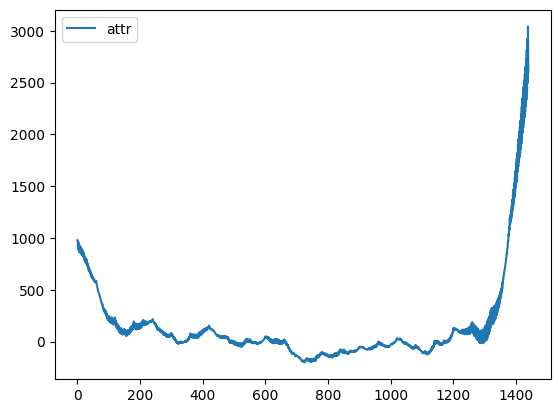

In [20]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

#### scaling

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
attr_df

,attr
0,1.912373
1,1.899713
2,1.726653
3,1.867390
4,1.698622
...,...
1435,5.207250
1436,6.389233
1437,5.411884
1438,6.664996


#### train_index구하기

In [22]:
index_list = []

for hyper_parameter in np.arange(0.01,1.01,0.01):
    append_idx = list(attr_df[(attr_df['attr']>hyper_parameter) | (attr_df['attr']<-hyper_parameter)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

100

In [23]:
len_list=[]
for i in range(100):
    len_list.append(len(index_list[i]))


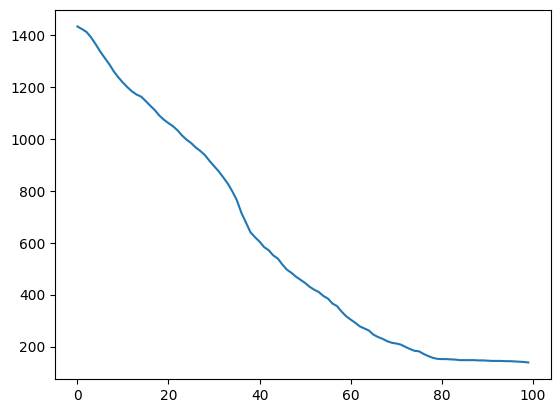

In [24]:
plt.plot(np.arange(100),len_list) # 포함되는 time_index의 갯수

In [25]:
for val_x,val_y in validation:
    print(val_x,val_y)

tensor([[[ 99460.,  90047.,  97806.,  ..., 109476., 107938., 110427.]],

        [[ 90047.,  97806.,  87141.,  ..., 107938., 110427., 112393.]],

        [[ 97806.,  87141.,  94147.,  ..., 110427., 112393., 107838.]],

        ...,

        [[ 74547.,  76519.,  69353.,  ...,  89959.,  83763., 150861.]],

        [[ 76519.,  69353.,  72669.,  ...,  83763., 150861.,  84639.]],

        [[ 69353.,  72669.,  67592.,  ..., 150861.,  84639.,  88357.]]],
       device='cuda:0') tensor([[[112393.]],

        [[107838.]],

        [[109474.]],

        [[106154.]],

        [[109562.]],

        [[104609.]],

        [[108481.]],

        [[104811.]],

        [[108068.]],

        [[101610.]],

        [[109562.]],

        [[102103.]],

        [[107085.]],

        [[101324.]],

        [[103611.]],

        [[ 97023.]],

        [[103033.]],

        [[ 97762.]],

        [[102938.]],

        [[ 95425.]],

        [[100112.]],

        [[ 92605.]],

        [[ 97253.]],

        [[ 92184.]

tensor([[[305801., 293006., 306019.,  ..., 306404., 332097., 304834.]],

        [[293006., 306019., 292792.,  ..., 332097., 304834., 328074.]],

        [[306019., 292792., 308067.,  ..., 304834., 328074., 299230.]],

        ...,

        [[305871., 281396., 311915.,  ..., 312909., 317899., 308514.]],

        [[281396., 311915., 288238.,  ..., 317899., 308514., 318760.]],

        [[311915., 288238., 313083.,  ..., 308514., 318760., 304316.]]],
       device='cuda:0') tensor([[[328074.]],

        [[299230.]],

        [[325866.]],

        [[314473.]],

        [[327980.]],

        [[318146.]],

        [[329267.]],

        [[314750.]],

        [[334032.]],

        [[314484.]],

        [[334893.]],

        [[314550.]],

        [[333011.]],

        [[316368.]],

        [[336622.]],

        [[314469.]],

        [[335627.]],

        [[310540.]],

        [[335048.]],

        [[309515.]],

        [[337647.]],

        [[325236.]],

        [[332595.]],

        [[324837.]

       device='cuda:0') tensor([[[54589.]],

        [[52759.]],

        [[54881.]],

        [[52438.]],

        [[55852.]],

        [[53034.]],

        [[56340.]],

        [[53324.]],

        [[54131.]],

        [[52008.]],

        [[53432.]],

        [[53528.]],

        [[54236.]],

        [[51701.]],

        [[55426.]],

        [[54883.]],

        [[57571.]],

        [[53518.]],

        [[54606.]],

        [[53264.]],

        [[54404.]],

        [[53467.]],

        [[55420.]],

        [[55432.]],

        [[54599.]],

        [[57219.]],

        [[54699.]],

        [[56153.]],

        [[54567.]],

        [[56532.]],

        [[52236.]],

        [[55232.]],

        [[53055.]],

        [[56122.]],

        [[53327.]],

        [[55332.]],

        [[53474.]],

        [[55664.]],

        [[52088.]],

        [[54954.]],

        [[52744.]],

        [[54710.]],

        [[52880.]],

        [[56392.]],

        [[53101.]],

        [[56451.]],

        [[

tensor([[[262666., 276630., 261875.,  ..., 216813., 229340., 220896.]],

        [[276630., 261875., 278046.,  ..., 229340., 220896., 225869.]],

        [[261875., 278046., 257700.,  ..., 220896., 225869., 221718.]],

        ...,

        [[229624., 217359., 228432.,  ..., 188761., 200094., 187724.]],

        [[217359., 228432., 212983.,  ..., 200094., 187724., 203247.]],

        [[228432., 212983., 224587.,  ..., 187724., 203247., 187415.]]],
       device='cuda:0') tensor([[[225869.]],

        [[221718.]],

        [[226421.]],

        [[219372.]],

        [[223008.]],

        [[220413.]],

        [[224895.]],

        [[220113.]],

        [[224896.]],

        [[218955.]],

        [[224699.]],

        [[216281.]],

        [[220093.]],

        [[215396.]],

        [[214651.]],

        [[212159.]],

        [[217840.]],

        [[219265.]],

        [[218982.]],

        [[215147.]],

        [[220369.]],

        [[216745.]],

        [[214135.]],

        [[222030.]

       device='cuda:0') tensor([[[197584.]],

        [[193645.]],

        [[202167.]],

        [[195376.]],

        [[199470.]],

        [[193319.]],

        [[199254.]],

        [[193218.]],

        [[198789.]],

        [[193798.]],

        [[200975.]],

        [[195340.]],

        [[200325.]],

        [[194048.]],

        [[198981.]],

        [[196711.]],

        [[203344.]],

        [[197033.]],

        [[203911.]],

        [[198278.]],

        [[201648.]],

        [[198660.]],

        [[198366.]],

        [[205286.]],

        [[201938.]],

        [[210289.]],

        [[205129.]],

        [[213694.]],

        [[211132.]],

        [[216923.]],

        [[207738.]],

        [[217898.]],

        [[205362.]],

        [[217760.]],

        [[205312.]],

        [[219186.]],

        [[207314.]],

        [[219518.]],

        [[209440.]],

        [[223862.]],

        [[206297.]],

        [[223014.]],

        [[206521.]],

        [[222673.]],

        

tensor([[[ 97152.,  93410.,  97749.,  ..., 103395.,  99170., 103273.]],

        [[ 93410.,  97749.,  92393.,  ...,  99170., 103273.,  97323.]],

        [[ 97749.,  92393.,  94468.,  ..., 103273.,  97323., 102155.]],

        ...,

        [[ 85870.,  82298.,  85843.,  ...,  91668.,  87325.,  91681.]],

        [[ 82298.,  85843.,  85797.,  ...,  87325.,  91681.,  88167.]],

        [[ 85843.,  85797.,  90281.,  ...,  91681.,  88167.,  89379.]]],
       device='cuda:0') tensor([[[ 97323.]],

        [[102155.]],

        [[ 96800.]],

        [[101213.]],

        [[ 93894.]],

        [[100698.]],

        [[ 94013.]],

        [[102999.]],

        [[ 95475.]],

        [[ 98919.]],

        [[ 93692.]],

        [[ 99729.]],

        [[ 93006.]],

        [[ 98725.]],

        [[ 90995.]],

        [[ 99042.]],

        [[ 91212.]],

        [[ 95602.]],

        [[ 89907.]],

        [[ 96044.]],

        [[ 92633.]],

        [[ 93161.]],

        [[ 91846.]],

        [[ 93309.]

In [26]:
val_x

tensor([[[ 97152.,  93410.,  97749.,  ..., 103395.,  99170., 103273.]],

        [[ 93410.,  97749.,  92393.,  ...,  99170., 103273.,  97323.]],

        [[ 97749.,  92393.,  94468.,  ..., 103273.,  97323., 102155.]],

        ...,

        [[ 85870.,  82298.,  85843.,  ...,  91668.,  87325.,  91681.]],

        [[ 82298.,  85843.,  85797.,  ...,  87325.,  91681.,  88167.]],

        [[ 85843.,  85797.,  90281.,  ...,  91681.,  88167.,  89379.]]],
       device='cuda:0')

In [27]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
out_list = []
num_epochs = 100
criterion = SMAPE()
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=200
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            
            outputs = outputs.view(-1,1)
            
            labels = labels.view(-1,1)  
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = criterion(pred,val_target).item()*100
    out_list.append(result)
    


changed
changed
changed
changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:50.409898921549754
changed
changed
changed
changed
changed
changed
1번째 모델 Training 완료 마지막 Epoch loss:49.041984435832184
changed
changed
changed
changed
changed
changed
changed
2번째 모델 Training 완료 마지막 Epoch loss:46.947958292825334
changed
changed
changed
changed
changed
changed
changed
changed
3번째 모델 Training 완료 마지막 Epoch loss:34.82365325291658
changed
changed
changed
changed
4번째 모델 Training 완료 마지막 Epoch loss:31.96113542998044
changed
changed
changed
changed
changed
changed
changed
5번째 모델 Training 완료 마지막 Epoch loss:39.12300782432482
changed
changed
changed
changed
changed
changed
6번째 모델 Training 완료 마지막 Epoch loss:36.60814129312098
changed
changed
changed
changed
changed
changed
changed
7번째 모델 Training 완료 마지막 Epoch loss:37.39273152011033
changed
changed
changed
changed
changed
changed
changed
8번째 모델 Training 완료 마지막 Epoch loss:43.478505266830325
changed
changed
changed
9번째 모델 Training 완료 마지막 E

changed
71번째 모델 Training 완료 마지막 Epoch loss:3.873655501168949
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
72번째 모델 Training 완료 마지막 Epoch loss:2.8455243578191696
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
73번째 모델 Training 완료 마지막 Epoch loss:4.647285833447818
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
74번째 모델 Training 완료 마지막 Epoch loss:4.452207961847135
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
85번째 모델 Training 완료 마지막 Epoch loss:2.0002463432965722
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
95번째 모델 Training 완료 마지막 Epoch loss:2.0005840766822267
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

In [28]:
val_y # 다음 예측 타겟값

tensor([[[ 97323.]],

        [[102155.]],

        [[ 96800.]],

        [[101213.]],

        [[ 93894.]],

        [[100698.]],

        [[ 94013.]],

        [[102999.]],

        [[ 95475.]],

        [[ 98919.]],

        [[ 93692.]],

        [[ 99729.]],

        [[ 93006.]],

        [[ 98725.]],

        [[ 90995.]],

        [[ 99042.]],

        [[ 91212.]],

        [[ 95602.]],

        [[ 89907.]],

        [[ 96044.]],

        [[ 92633.]],

        [[ 93161.]],

        [[ 91846.]],

        [[ 93309.]],

        [[ 89432.]],

        [[ 91668.]],

        [[ 87325.]],

        [[ 91681.]],

        [[ 88167.]],

        [[ 89379.]],

        [[ 88208.]]], device='cuda:0')

In [29]:
val_x # 예측 하는 값

tensor([[[ 97152.,  93410.,  97749.,  ..., 103395.,  99170., 103273.]],

        [[ 93410.,  97749.,  92393.,  ...,  99170., 103273.,  97323.]],

        [[ 97749.,  92393.,  94468.,  ..., 103273.,  97323., 102155.]],

        ...,

        [[ 85870.,  82298.,  85843.,  ...,  91668.,  87325.,  91681.]],

        [[ 82298.,  85843.,  85797.,  ...,  87325.,  91681.,  88167.]],

        [[ 85843.,  85797.,  90281.,  ...,  91681.,  88167.,  89379.]]],
       device='cuda:0')

In [30]:
result/68

0.03281484138877953

In [31]:
val_x.size()

torch.Size([31, 1, 1440])

In [32]:
model(X_test)

tensor([[[87249.3828]]], device='cuda:0', grad_fn=<ViewBackward0>)

In [33]:
out_df = pd.DataFrame({"out":out_list})

<AxesSubplot: >

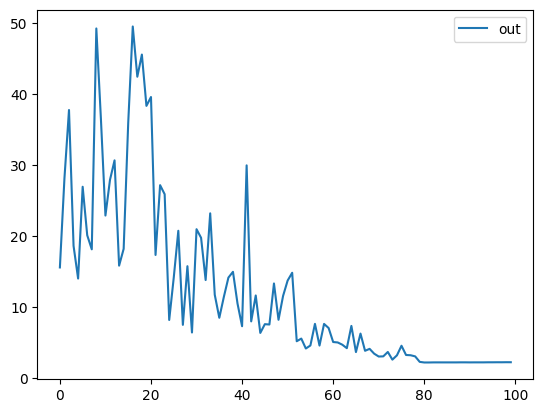

In [34]:
out_df.plot()

In [35]:
out_df.min()

out    2.197219
dtype: float64

In [36]:
out_df[out_df['out']==out_df['out'].min()]

,out
80,2.197219
81,2.197219


## Result
* 퍼센트로 하면, 더이상 빠지는 것이 없어지는 지점이 오는데 그 경우에 위처럼 더이상 감소하지 않는 것을 확인할 수 있다.

In [37]:
attr_df.describe()

,attr
count,1440.000000
mean,0.000000
std,1.000347
min,-0.806477
25%,-0.444378
50%,-0.296046
75%,-0.043315
max,6.664996
